# Main Rn222 analysis

This notebook contains the primary analysis of our sensitivity as a function of the Rn222 component.

## Table of contents
* ### [Plotting the Rn222 distributions](#distributions)
* ### [D-023 (normal copper) median sensitivity](#d023mediansensitivity)
* ### [Inspecting lambda curves for D-023](#d023inspectinglambdacurves)
* ### [D-024 (EFCu) median sensitivity](#d024mediansensitivity)


In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/Rn222Study


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os
import time

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib

importlib.reload( nEXOFitWorkspace )

<module 'nEXOFitWorkspace' from '../../../modules/nEXOFitWorkspace.py'>

In [4]:
# What sensitivity do I get for the "nominal" model?

def ComputeHalflifeFromNumCounts( counts ):
    
    # Returns the half life which would give (on average) the input number of signal counts
    
    N_A = 6.02e23 # atoms/mol
    FidMass = 3281 # kg
    AtomicMass = 135.8 # g/mol
    EnrichmentFraction = 0.9
    SigEfficiency = 0.96
    Livetime = 10 # years
    
    return FidMass*1.e3 / AtomicMass * N_A * EnrichmentFraction * Livetime * \
            SigEfficiency * np.log(2) / counts

 

In [5]:
ComputeHalflifeFromNumCounts( 2.44 )
    


3.569869405743919e+28

<a class="anchor" id="distributions"></a>
# Rn222 PDFs

In the `Sensitivity2020_config.yaml` file, there are three PDFs that get added to the Rn222 component during grouping. They are:
* Rn222_ActiveLXe
* Rn222_InactiveLXe
* Rn222_Cathode

Let's take a look at each of these in the component table.

In [6]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace( \
                    config='../../config/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml' )

workspace.LoadComponentsTableFromFile('/p/vast1/nexo/sensitivity2020/pdfs/component_tables/'+\
                    'ComponentsTable_D-023_merged-v10b_Optimized_DNN_Standoff_Binning_version1.h5')







Loading input data froma previously-generated components table....

Loaded dataframe with 171 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	Material
	Radioassay ID
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']


In [7]:
workspace.CreateGroupedPDFs()


Creating grouped PDFs....
no sigma for Rn222_HFE (R-053.9.1.1)
no sigma for Rn222_FieldRingsRadon (R-088.4.1.1)
no sigma for Rn222_CathodeRadon (R-088.1.1.1)
no sigma for Rn222_ActiveLXe (R-088.2.1.1)
no sigma for Ar42_ActiveLXe (R-088.2.1.1)
no sigma for Rn222_InactiveLXe (R-088.3.1.1)
no sigma for Ar42_InactiveLXe (R-088.3.1.1)

ERROR: No histogram available for K40_OuterCryostatWTSupport

ERROR: No histogram available for Co60_OuterCryostatWTSupport
	Group:                              	Expected Counts:
	Far                                 	      5035.5790
	Vessel_U238                         	     17228.4795
	Vessel_Th232                        	      2748.3922
	FullTPC_Co60                        	     12171.6448
	Internals_U238                      	     23859.7902
	Internals_Th232                     	      4826.8827
	Rn222                               	     21223.2388
	FullTPC_K40                         	  41173540.8786
	B8nu                                	        12.9712
	

In [8]:
workspace.df_group_pdfs.head()

,Group,Histogram,TotalExpectedCounts
0,Far,"Hist(14 bins in [0.0,1.0], 250 bins in [1000.0...",5035.579011
1,Vessel_U238,"Hist(14 bins in [0.0,1.0], 250 bins in [1000.0...",17228.479542
2,Vessel_Th232,"Hist(14 bins in [0.0,1.0], 250 bins in [1000.0...",2748.392153
3,FullTPC_Co60,"Hist(14 bins in [0.0,1.0], 250 bins in [1000.0...",12171.644803
4,Internals_U238,"Hist(14 bins in [0.0,1.0], 250 bins in [1000.0...",23859.790158


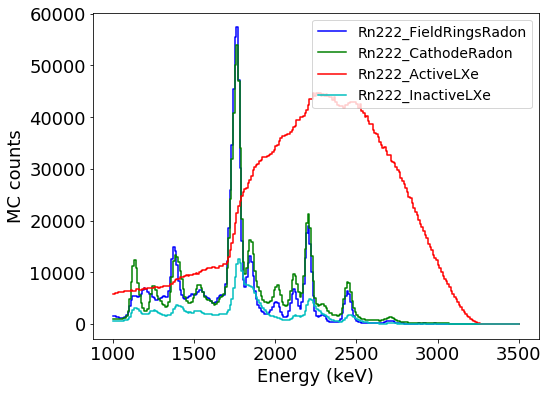

In [9]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

for index,row in workspace.df_components.iterrows():
    if 'Rn222' in row['PDFName'] and 'HFE' not in row['PDFName']:
        hl.plot1d(row['Histogram'].project([1]),\
                  label=row['PDFName'])
        
plt.xlabel('Energy (keV)')
plt.ylabel('MC counts')
plt.legend(fontsize=14,loc='upper right')

<a class="anchor" id="d023mediansensitivity"></a>
# D-023 (normal copper) median sensitivity vs. Rn222

Here we load in all the calculations, then compute the median 90% upper limit. The sensitivity stored in the files is computed assuming the 90% threshold is at the Wilks' limit (2.706). 

In [22]:
categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','30.0x','100.0x']
#categories_list = ['01.0x']
#outputdir = '/p/lustre2/lenardo1/sensitivity_output/Dec29_Rn222Study_merged-v10b_OptimizedV1Binning/'
outputdir = '/p/lustre2//lenardo1/sensitivity_output/'+\
            'Mar1_Rn222Study_merged-v11_OptimizedV1Binning_D024/'


all_files = os.listdir(outputdir)
h5_files = [filename for filename in all_files if 'reanalyzed' in filename and filename.endswith('.h5')]

dfdict = dict()

start_time = time.time()
for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list = [pd.read_hdf(outputdir+filename) for filename in h5_files if '_'+category+'_' in filename]
    dfdict[category] = pd.concat(df_list,ignore_index=True)
    print('---> Loaded {} toy datasets at {:4.4} min'.format(len(dfdict[category]),\
                                                             (time.time()-start_time)/60.))


Loading data for 0.01x
---> Loaded 4900 toy datasets at 0.02615 min
Loading data for 00.1x
---> Loaded 5000 toy datasets at 0.05341 min
Loading data for 00.3x
---> Loaded 5000 toy datasets at 0.07818 min
Loading data for 01.0x
---> Loaded 5000 toy datasets at 0.1027 min
Loading data for 03.0x
---> Loaded 5000 toy datasets at 0.1284 min
Loading data for 10.0x
---> Loaded 3200 toy datasets at 0.1456 min
Loading data for 30.0x
---> Loaded 5000 toy datasets at 0.1719 min
Loading data for 100.0x
---> Loaded 4900 toy datasets at 0.1972 min


In [23]:
# Get the median values of lambda

maskdict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict[key])/len(maskdict[key])))
            
    
        

Running 0.01x
---> Convergence fraction: 0.946
Running 00.1x
---> Convergence fraction: 0.951
Running 00.3x
---> Convergence fraction: 0.945
Running 01.0x
---> Convergence fraction: 0.922
Running 03.0x
---> Convergence fraction: 0.898
Running 10.0x
---> Convergence fraction: 0.92
Running 30.0x
---> Convergence fraction: 0.911
Running 100.0x
---> Convergence fraction: 0.897


In [24]:
dfdict['01.0x'][['90CL_crossing','90CL_crossing_EXACT']]

,90CL_crossing,90CL_crossing_EXACT
0,19.861986,20.012001
1,7.480748,7.830783
2,11.071107,11.301130
3,4.880488,4.990499
4,7.300730,7.630763
5,-1.000000,-1.000000
6,7.580758,7.890789
7,3.710371,3.040304
8,3.390339,2.490249
9,3.750375,3.110311


Running 0.01x
---> Median 90%CL on signal counts: 5.200520052005201
Running 00.1x
---> Median 90%CL on signal counts: 5.540554055405541
Running 00.3x
---> Median 90%CL on signal counts: 5.7905790579057905
Running 01.0x
---> Median 90%CL on signal counts: 6.590659065906591
Running 03.0x
---> Median 90%CL on signal counts: 7.530753075307531
Running 10.0x
---> Median 90%CL on signal counts: 9.36093609360936
Running 30.0x
---> Median 90%CL on signal counts: 11.541154115411542
Running 100.0x
---> Median 90%CL on signal counts: 17.56675667566757


Text(0.5, 0, '90% CL on signal counts for given toy')

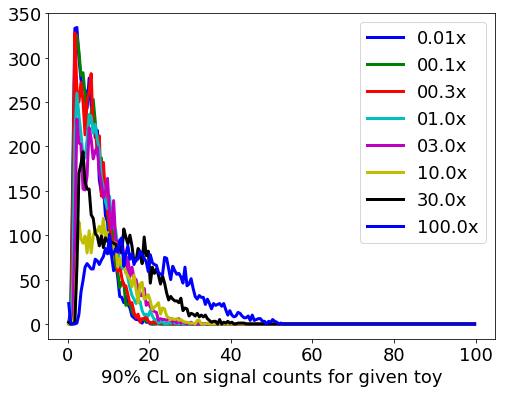

In [25]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

histdict = dict()
mediandict = dict()
medianerr_dict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    histdict[key] = hl.hist(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]], bins=np.linspace(0.,100.,201))
    
    mediandict[key] = np.median(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]])
    medianerr_dict[key] = np.std(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]]) / np.sqrt(np.sum(maskdict[key]))
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict[key]))
    
    #hl.plot1d(histdict[key],label=key,linewidth=3)
    
    bincenters = (histdict[key].bins[0][:-1] + histdict[key].bins[0][1:])/2.
    binvals = histdict[key].values
    
    plt.plot(bincenters,binvals,label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
 

In [27]:

def BrazilPlot(hist, median, quantiles68=[None,None], quantiles95=[None,None],\
               save=False, label=''):
    
    hl.plot1d(hist,color='k',linewidth=3,label='90% UL distribution')
    
    y1 = 0.
    y2 = np.max(hist.values)*1.1
    
    xmed = np.ones(10)*median
    ymed = np.linspace(y1,y2,10)
    plt.plot(xmed,ymed,'--b',label='Median = {:3.3} cts'.format(median))
    
    plt.fill_between( np.linspace(quantiles95[0],quantiles68[0],10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.9,0.9,0.),alpha=0.4)
    plt.fill_between( np.linspace(quantiles68[0],median,10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.,0.9,0.),alpha=0.4)
    plt.fill_between( np.linspace(median,quantiles68[1],10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.,0.9,0.),alpha=0.4,\
                    label='68% quantile = [{:3.3}, {:3.3}]'.format(quantiles68[0],quantiles68[1]))
    plt.fill_between( np.linspace(quantiles68[1],quantiles95[1],10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.9,0.9,0.),alpha=0.4,\
                    label='95% quantile = [{:3.3}, {:3.3}]'.format(quantiles95[0],quantiles95[1]))
    
    
    plt.xlabel('Nsignal')
    plt.ylabel('Number of toy datasets')
    
    print('Median sensitivity: {:4.4} yrs'.format(ComputeHalflifeFromNumCounts(median)))
    print('Central 68% quantile: {:4.4} -- {:4.4} yrs'.format( \
                                    ComputeHalflifeFromNumCounts(quantiles68[1]),\
                                    ComputeHalflifeFromNumCounts(quantiles68[0])))
    print('Central 95% quantile: {:4.4} -- {:4.4} yrs'.format( \
                                    ComputeHalflifeFromNumCounts(quantiles95[1]),\
                                    ComputeHalflifeFromNumCounts(quantiles95[0])))
    
    plt.xlim(0.,50.)
    plt.ylim(y1,y2)
    plt.legend(loc='upper right',fontsize=13,framealpha=1.)
    if save:
        plt.savefig('Plots/brazil_plot_{}.png'.format(label),dpi=200,bbox_inches='tight')
    
    
##########################################################################



def BrazilPlotGrey(hist, median, quantiles68=[None,None], quantiles95=[None,None],\
               save=False, label=''):
    
    hl.plot1d(hist,color='b',linewidth=3,label='90% UL distribution')
    
    y1 = 0.
    y2 = np.max(hist.values)*1.1
    
    xmed = np.ones(10)*median
    ymed = np.linspace(y1,y2,10)
    plt.plot(xmed,ymed,'--k',label='Median = {:3.3} cts'.format(median))
    
    plt.fill_between( np.linspace(quantiles95[0],quantiles68[0],10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.8,0.8,0.8),alpha=0.5)
    plt.fill_between( np.linspace(quantiles68[0],median,10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.6,0.6,0.6),alpha=0.5)
    plt.fill_between( np.linspace(median,quantiles68[1],10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.6,0.6,0.6),alpha=0.5,\
                    label='68% quantile = [{:3.3}, {:3.3}]'.format(quantiles68[0],quantiles68[1]))
    plt.fill_between( np.linspace(quantiles68[1],quantiles95[1],10),\
                    np.ones(10)*y1,np.ones(10)*y2,color=(0.8,0.8,0.8),alpha=0.5,\
                    label='95% quantile = [{:3.3}, {:3.3}]'.format(quantiles95[0],quantiles95[1]))
    
    
    plt.xlabel('Nsignal')
    plt.ylabel('Number of toy datasets')
    
    print('Median sensitivity: {:4.4} yrs'.format(ComputeHalflifeFromNumCounts(median)))
    print('Central 68% quantile: {:4.4} -- {:4.4} yrs'.format( \
                                    ComputeHalflifeFromNumCounts(quantiles68[1]),\
                                    ComputeHalflifeFromNumCounts(quantiles68[0])))
    print('Central 95% quantile: {:4.4} -- {:4.4} yrs'.format( \
                                    ComputeHalflifeFromNumCounts(quantiles95[1]),\
                                    ComputeHalflifeFromNumCounts(quantiles95[0])))
    
    plt.xlim(0.,50.)
    plt.ylim(y1,y2)
    plt.legend(loc='upper right',fontsize=13,framealpha=1.)
    if save:
        plt.savefig('Plots/brazil_plot_grey_{}.png'.format(label),dpi=200,bbox_inches='tight')
    
    
    


In [ ]:
    
    
    
    
    
# Make sensitivity "Brazil Plot" for the nominal case.
this_median = np.median(dfdict['01.0x']['90CL_crossing_EXACT'].loc[maskdict['01.0x']])
this_68_quantile = [ np.quantile(dfdict['01.0x']['90CL_crossing_EXACT'].loc[maskdict['01.0x']],0.16),\
                   np.quantile(dfdict['01.0x']['90CL_crossing_EXACT'].loc[maskdict['01.0x']],0.84)]
this_95_quantile = [ np.quantile(dfdict['01.0x']['90CL_crossing_EXACT'].loc[maskdict['01.0x']],0.025),\
                   np.quantile(dfdict['01.0x']['90CL_crossing_EXACT'].loc[maskdict['01.0x']],0.975)]

BrazilPlot(histdict['01.0x'],\
           median=this_median,\
           quantiles68=this_68_quantile,\
           quantiles95=this_95_quantile,\
          save=True,\
          label='nominal_case_D023')

Running 0.01x
---> Median 90%CL on signal counts: 5.000500050005001
Running 00.1x
---> Median 90%CL on signal counts: 5.300530053005301
Running 00.3x
---> Median 90%CL on signal counts: 5.500550055005501
Running 01.0x
---> Median 90%CL on signal counts: 6.260626062606261
Running 03.0x
---> Median 90%CL on signal counts: 7.110711071107111
Running 10.0x
---> Median 90%CL on signal counts: 8.750875087508751
Running 30.0x
---> Median 90%CL on signal counts: 11.651165116511653
Running 100.0x
---> Median 90%CL on signal counts: 16.981698169816983


Text(0.5, 0, '90% CL on signal counts for given toy')

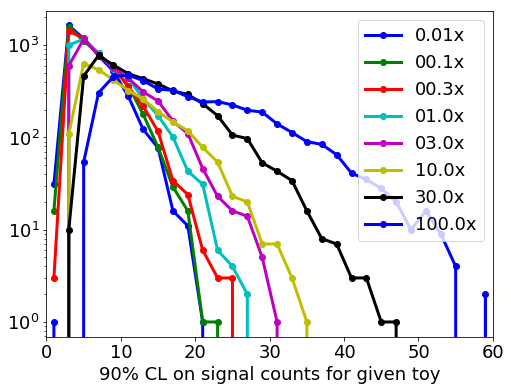

In [27]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

histdict = dict()
mediandict = dict()
medianerr_dict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    #if float(key[:-1]) > 1.: continue
    
    histdict[key] = hl.hist(dfdict[key]['90CL_crossing'].loc[maskdict[key]], bins=np.linspace(0.,100.,51))
    
    mediandict[key] = np.median(dfdict[key]['90CL_crossing'].loc[maskdict[key]])
    medianerr_dict[key] = np.std(dfdict[key]['90CL_crossing'].loc[maskdict[key]]) / np.sqrt(np.sum(maskdict[key]))
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict[key]))
    
    #hl.plot1d(histdict[key],label=key,linewidth=3)
    
    bincenters = (histdict[key].bins[0][:-1] + histdict[key].bins[0][1:])/2.
    binvals = histdict[key].values
    
    plt.plot(bincenters,binvals,'-o',label=key,linewidth=3)

plt.xlim(0,60.)

plt.yscale('log')
    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')

In [28]:
# Loop through mediandict and save as numpy arrays
scale_factors_float = []
medians_float = []
for scale_factor,median in mediandict.items():
    scale_factors_float.append(float(scale_factor[:-1]))
    medians_float.append(float(median))
scale_factors_float = np.array(scale_factors_float)
medians_float = np.array(medians_float)

# Sort the values and build the array
sorted_idxs = np.argsort(scale_factors_float)
output_array = np.vstack([scale_factors_float[sorted_idxs],\
                         medians_float[sorted_idxs]])
output_array = np.transpose(output_array)

# Save to a text file
np.savetxt('LimitsData/median_90CL_limits_wilks_theorem_d023.txt',output_array)

### Estimating the halflife sensitivity for the nominal model

Sensitivity at 0.01: 1.7419e+28 yrs
Sensitivity at  0.1: 1.6433e+28 yrs
Sensitivity at  0.3: 1.5836e+28 yrs
Sensitivity at  1.0: 1.3913e+28 yrs
Sensitivity at  3.0: 1.225e+28 yrs
Sensitivity at 10.0: 9.9538e+27 yrs
Sensitivity at 30.0: 7.4761e+27 yrs
Sensitivity at 100.0: 5.1293e+27 yrs


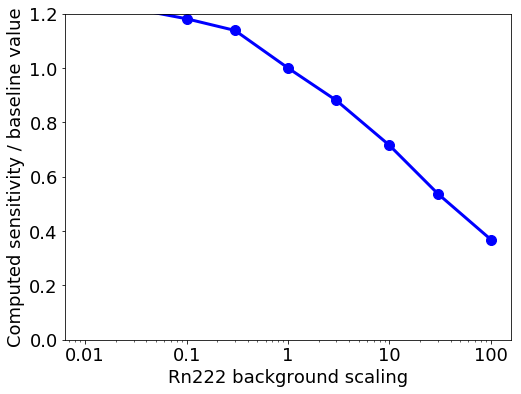

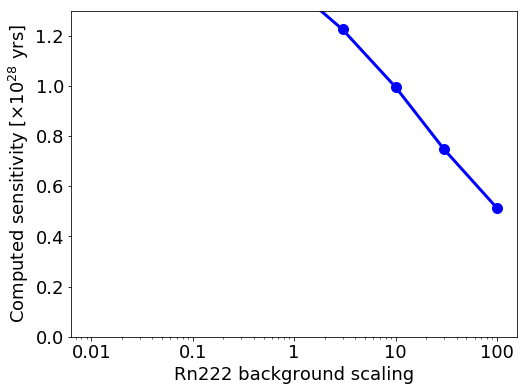

In [29]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

x_points = []
y_points = []
y_err = []
y_points_relative = []

for key,value in mediandict.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
    err = float(medianerr_dict[key])
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points.append(factor)
    y_points.append(ComputeHalflifeFromNumCounts(value))
    y_err.append( err/value**2 )
    y_points_relative.append((1/value)/(1/mediandict['01.0x']))
    
    
x_points = np.array(x_points)
y_points = np.array(y_points)
y_err = np.array(y_err)
y_points_relative = np.array(y_points_relative)
    
sorted_idxs = np.argsort(x_points)

x_points = x_points[sorted_idxs]
y_points = y_points[sorted_idxs]
y_err = y_err[sorted_idxs]
y_points_relative = y_points_relative[sorted_idxs]
    
    
plt.figure(1)    
plt.plot(x_points,y_points_relative,'-ob',markersize=10,linewidth=3)
plt.xscale('log')
plt.ylim(0.,1.2)
plt.ylabel('Computed sensitivity / baseline value')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])

plt.savefig('rn222_sensitivity_vs_scale_factor_relative.png',dpi=200,bbox_inches='tight')

plt.figure(2)
plt.errorbar(x_points,y_points/1.e28,yerr=y_err/1.e28,fmt='-ob',markersize=10,linewidth=3)
plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.,1.3)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])

for i in range(len(x_points)):
    print('Sensitivity at {:4.4}: {:5.5} yrs'.format(x_points[i],y_points[i]))
    
output_df = pd.DataFrame({'Rn222 scaling': x_points, 'Sensitivity (yrs)': y_points})
output_df.to_csv('../PaperPlots/Data/d023_sensitivity_vs_rn222.csv',index=False)

plt.savefig('rn222_sensitivity_vs_scale_factor_absolute.png',dpi=200,bbox_inches='tight')


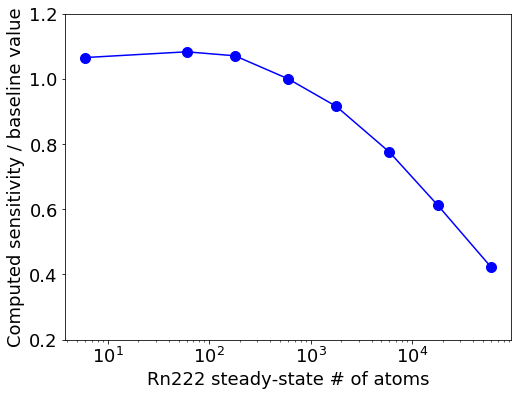

In [26]:
plt.plot(x_points*600,y_points_relative,'-ob',markersize=10)
plt.xscale('log')
plt.ylim(0.2,1.2)
plt.ylabel('Computed sensitivity / baseline value')
plt.xlabel('Rn222 steady-state # of atoms')
#plt.xticks([0.1,1.,10.],['0.1','1','10'])

plt.savefig('rn222_sensitivity_vs_atoms.png',dpi=200,bbox_inches='tight')

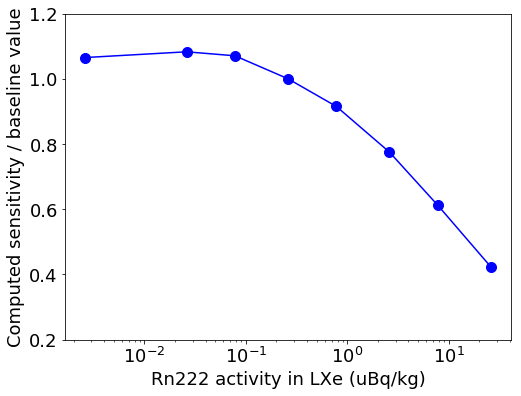

In [27]:
plt.plot(x_points*0.26,y_points_relative,'-ob',markersize=10)
plt.xscale('log')
plt.ylim(0.2,1.2)
plt.ylabel('Computed sensitivity / baseline value')
plt.xlabel('Rn222 activity in LXe (uBq/kg)')
#plt.xticks([0.1,1.,10.],['0.1','1','10'])

plt.savefig('rn222_sensitivity_vs_uBq_per_kg.png',dpi=200,bbox_inches='tight')

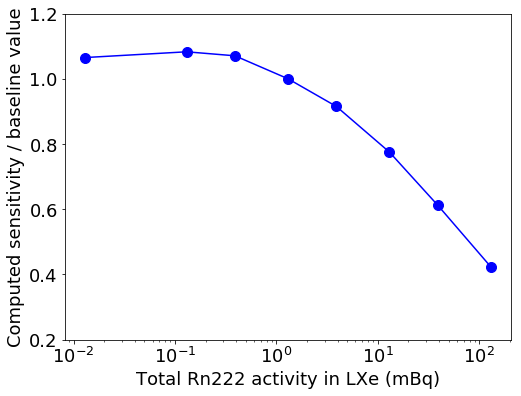

In [28]:
plt.plot(x_points*0.26*5000/1e3,y_points_relative,'-ob',markersize=10)
plt.xscale('log')
plt.ylim(0.2,1.2)
plt.ylabel('Computed sensitivity / baseline value')
plt.xlabel('Total Rn222 activity in LXe (mBq)')
#plt.xticks([0.1,1.,10.],['0.1','1','10'])

plt.savefig('rn222_sensitivity_vs_mBq.png',dpi=200,bbox_inches='tight')

<a class="anchor" id="d024mediansensitivity"></a>
# D-24 (EFCu) median sensitivity


In [10]:
#categories_list = ['00.3x','01.0x','03.0x','10.0x']
categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','30.0x','100.0x']
#categories_list = ['01.0x']
outputdir_d024 = '/p/lustre2/lenardo1/sensitivity_output/Mar1_Rn222Study_merged-v11_OptimizedV1Binning_D024/'

all_files_d024 = os.listdir(outputdir_d024)
h5_files_d024 = [filename for filename in all_files_d024 if 'reanalyzed' in filename and filename.endswith('.h5')]

dfdict_d024 = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_d024 = [pd.read_hdf(outputdir_d024+filename) for filename in h5_files_d024 if '_'+category+'_' in filename]
    dfdict_d024[category] = pd.concat(df_list_d024,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_d024[category])))
    
 
    
    
    

Loading data for 0.01x
---> Loaded 4900 toy datasets
Loading data for 00.1x
---> Loaded 5000 toy datasets
Loading data for 00.3x
---> Loaded 5000 toy datasets
Loading data for 01.0x
---> Loaded 5000 toy datasets
Loading data for 03.0x
---> Loaded 5000 toy datasets
Loading data for 10.0x
---> Loaded 3200 toy datasets
Loading data for 30.0x
---> Loaded 5000 toy datasets
Loading data for 100.0x
---> Loaded 4900 toy datasets


In [11]:
dfdict_d024['01.0x'].head()

,90CL_crossing,best_fit_converged,best_fit_covar,best_fit_errors,best_fit_iterations,best_fit_nll,best_fit_parameters,fixed_fit_acc_covar,fixed_fit_converged,fixed_fit_errors,fixed_fit_parameters,input_parameters,lambda,num_iterations,num_signal,90CL_crossing_EXACT
0,19.861986,True,True,"{'Num_Far': 622.2180894721967, 'Num_Vessel_U23...",2,-4.223853,"{'Num_Far': 4163.388274734835, 'Num_Vessel_U23...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","{'Num_Far': 426.57357243944784, 'Num_Vessel_U2...","{'Num_Far': 4100.495488267181, 'Num_Vessel_U23...","[4149.854540646954, 1689.664157794171, 1338.87...","[3.2315863968680762, 1.9618290918667247, 1.137...","[2.0, 1.0, 2.0, 3.0, 4.0, 1.0, 1.0, 1.0, 2.0, ...","[1e-06, 1.4000009999999998, 2.800001, 4.200000...",20.012001
1,7.480748,True,True,"{'Num_Far': 502.6549502386565, 'Num_Vessel_U23...",3,-0.788519,"{'Num_Far': 6013.159490647106, 'Num_Vessel_U23...","[True, True, False, True, False, True, True, T...","[True, True, False, True, True, True, True, Tr...","{'Num_Far': 598.6673492813525, 'Num_Vessel_U23...","{'Num_Far': 6084.918659393507, 'Num_Vessel_U23...","[5340.520932441273, 3598.096396309794, 403.874...","[0.0008394539105938126, 0.2827036186090015, 0....","[4.0, 2.0, 10.0, 1.0, 10.0, 6.0, 4.0, 1.0, 3.0...","[1e-06, 1.4000009999999998, 2.800001, 4.200000...",7.830783
2,11.071107,True,True,"{'Num_Far': 325.31743401169524, 'Num_Vessel_U2...",1,-4.763367,"{'Num_Far': 5458.033635396142, 'Num_Vessel_U23...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","{'Num_Far': 435.87697114122875, 'Num_Vessel_U2...","{'Num_Far': 5477.086747910648, 'Num_Vessel_U23...","[5638.24084142738, 1200.9456413677372, 528.314...","[1.5660985208453884, 0.3824059724078559, 0.022...","[2.0, 1.0, 1.0, 1.0, 4.0, 1.0, 2.0, 1.0, 1.0, ...","[1e-06, 1.4000009999999998, 2.800001, 4.200000...",11.301130
3,4.880488,True,True,"{'Num_Far': 410.54605149132794, 'Num_Vessel_U2...",1,-8.042534,"{'Num_Far': 4757.231398032587, 'Num_Vessel_U23...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","{'Num_Far': 421.9133567792078, 'Num_Vessel_U23...","{'Num_Far': 4751.004650302679, 'Num_Vessel_U23...","[5568.643314143213, 2862.083167031055, 235.861...","[-3.2255307999662364e-05, 0.6801646778443651, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, ...","[1e-06, 1.4000009999999998, 2.800001, 4.200000...",4.990499
4,7.300730,True,True,"{'Num_Far': 377.8942831000859, 'Num_Vessel_U23...",1,-3.027194,"{'Num_Far': 6257.278424883065, 'Num_Vessel_U23...","[True, True, True, True, True, True, True, Fal...","[True, True, True, True, True, True, True, Fal...","{'Num_Far': 379.8277691143335, 'Num_Vessel_U23...","{'Num_Far': 6250.511485893421, 'Num_Vessel_U23...","[6049.808625306834, 3693.7496254805333, 239.06...","[1.0056351743337189e-05, 0.2728812567641157, 0...","[1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 2.0, 10.0, 10.0...","[1e-06, 1.4000009999999998, 2.800001, 4.200000...",7.630763


In [12]:
# Get the median values of lambda

maskdict_d024 = dict()

for key, df in dfdict_d024.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 or \
            not row['best_fit_covar']:
        #if not row['best_fit_converged']:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_d024[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_d024[key])/len(maskdict_d024[key])))
            
    

Running 0.01x
---> Convergence fraction: 0.994
Running 00.1x
---> Convergence fraction: 0.995
Running 00.3x
---> Convergence fraction: 0.99
Running 01.0x
---> Convergence fraction: 0.98
Running 03.0x
---> Convergence fraction: 0.971
Running 10.0x
---> Convergence fraction: 0.979
Running 30.0x
---> Convergence fraction: 0.978
Running 100.0x
---> Convergence fraction: 0.971


In [14]:
histdict_d024 = dict()
mediandict_d024 = dict()
medianerrdict_d024 = dict()

# Save the distribution as a text file
dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024[key]].to_csv('../PaperPlots/Data/d024_90percent_upper_limits_rn222x1.csv',index=False,header=True)



for key, df in dfdict_d024.items():
    print('Running {}'.format(key))
    
    histdict_d024[key] = hl.hist(dfdict_d024[key]['90CL_crossing_EXACT'].loc[maskdict_d024[key]], bins=np.linspace(0.,50.,101))
    
    mediandict_d024[key] = np.median(dfdict_d024[key]['90CL_crossing_EXACT'].loc[maskdict_d024[key]])
    
    medianerrdict_d024[key] = np.std(dfdict_d024[key]['90CL_crossing_EXACT'].loc[maskdict_d024[key]])/np.sqrt(np.sum(maskdict_d024[key]))
    
    print('---> Median 90%CL on signal counts: {:4.4} +/- {:4.4}'.format(mediandict_d024[key],medianerrdict_d024[key]))
    

Running 0.01x
---> Median 90%CL on signal counts: 5.221 +/- 0.04845
Running 00.1x
---> Median 90%CL on signal counts: 5.551 +/- 0.05016
Running 00.3x
---> Median 90%CL on signal counts: 5.831 +/- 0.053
Running 01.0x
---> Median 90%CL on signal counts: 6.641 +/- 0.06073
Running 03.0x
---> Median 90%CL on signal counts: 7.581 +/- 0.07103
Running 10.0x
---> Median 90%CL on signal counts: 9.431 +/- 0.1045
Running 30.0x
---> Median 90%CL on signal counts: 11.55 +/- 0.1105
Running 100.0x
---> Median 90%CL on signal counts: 17.23 +/- 0.1456


Median sensitivity: 1.312e+28 yrs
Central 68% quantile: 7.488e+27 -- 2.934e+28 yrs
Central 95% quantile: 5.014e+27 -- 5.064e+28 yrs


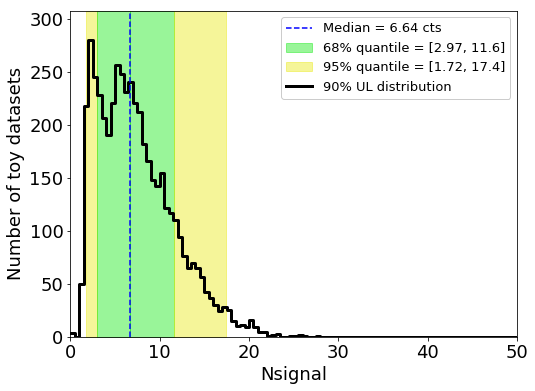

In [26]:
# Make sensitivity "Brazil Plot" for the nominal case.
this_median = np.median(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']])
this_68_quantile = [ np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.16),\
                   np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.84)]
this_95_quantile = [ np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.025),\
                   np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.975)]

BrazilPlot(histdict_d024['01.0x'],\
           median=this_median,\
           quantiles68=this_68_quantile,\
           quantiles95=this_95_quantile,\
          save=True,\
          label='nominal_case_D024')

Median sensitivity: 1.312e+28 yrs
Central 68% quantile: 7.488e+27 -- 2.934e+28 yrs
Central 95% quantile: 5.014e+27 -- 5.064e+28 yrs


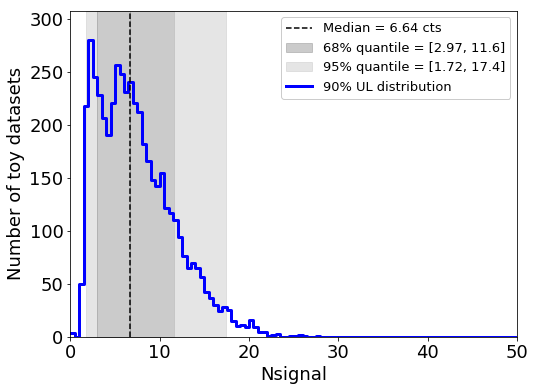

In [28]:
# Make sensitivity "Brazil Plot" for the nominal case.
this_median = np.median(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']])
this_68_quantile = [ np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.16),\
                   np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.84)]
this_95_quantile = [ np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.025),\
                   np.quantile(dfdict_d024['01.0x']['90CL_crossing_EXACT'].loc[maskdict_d024['01.0x']],0.975)]

BrazilPlotGrey(histdict_d024['01.0x'],\
           median=this_median,\
           quantiles68=this_68_quantile,\
           quantiles95=this_95_quantile,\
          save=True,\
          label='nominal_case_D024')

Running 0.01x
---> Median 90%CL on signal counts: 5.221 +/- 0.04845
Running 00.1x
---> Median 90%CL on signal counts: 5.551 +/- 0.05016
Running 00.3x
---> Median 90%CL on signal counts: 5.831 +/- 0.053
Running 01.0x
---> Median 90%CL on signal counts: 6.641 +/- 0.06073
Running 03.0x
---> Median 90%CL on signal counts: 7.581 +/- 0.07103
Running 10.0x
---> Median 90%CL on signal counts: 9.431 +/- 0.1045
Running 30.0x
---> Median 90%CL on signal counts: 11.55 +/- 0.1105
Running 100.0x
---> Median 90%CL on signal counts: 17.23 +/- 0.1456


Text(0.5, 0, '90% CL on signal counts for given toy')

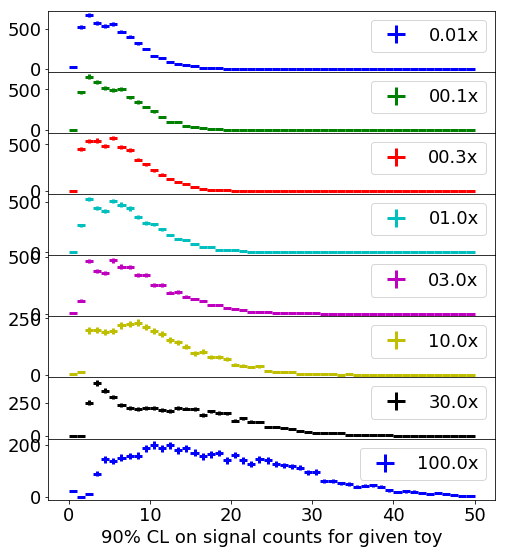

In [31]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,9)

histdict_d024 = dict()
mediandict_d024 = dict()
medianerrdict_d024 = dict()

fig,ax = plt.subplots(ncols=1,nrows=len(dfdict_d024.keys()),\
                      sharex=True,gridspec_kw={'hspace':0})

counter = 0
for key, df in dfdict_d024.items():
    print('Running {}'.format(key))
    
    histdict_d024[key] = hl.hist(dfdict_d024[key]['90CL_crossing_EXACT'].loc[maskdict_d024[key]], bins=np.linspace(0.,50.,51))
    
    mediandict_d024[key] = np.median(dfdict_d024[key]['90CL_crossing_EXACT'].loc[maskdict_d024[key]])
    
    medianerrdict_d024[key] = np.std(dfdict_d024[key]['90CL_crossing_EXACT'].loc[maskdict_d024[key]])/np.sqrt(np.sum(maskdict_d024[key]))
    
    print('---> Median 90%CL on signal counts: {:4.4} +/- {:4.4}'.format(mediandict_d024[key],medianerrdict_d024[key]))
    
    color_idx = counter % len(colors)
    
    hl.plot1d(ax[counter],histdict_d024[key],label=key,\
              linewidth=3,crosses=True,color=colors[color_idx])
    #hl.plot1d(histdict[key],label=key,linewidth=3)
    
#     bincenters = (histdict_d024[key].bins[0][:-1] + histdict_d024[key].bins[0][1:])/2.
#     binvals = histdict_d024[key].values
    
#     plt.plot(bincenters,binvals,label=key,linewidth=3)

    ax[counter].legend()

    counter += 1
    
#plt.legend()
ax[counter-1].set_xlabel('90% CL on signal counts for given toy')
#plt.yscale('log')            


D024 Sensitivity at 0.01: 1.6685e+28 yrs
D024 Sensitivity at  0.1: 1.5693e+28 yrs
D024 Sensitivity at  0.3: 1.4939e+28 yrs
D024 Sensitivity at  1.0: 1.3117e+28 yrs
D024 Sensitivity at  3.0: 1.149e+28 yrs
D024 Sensitivity at 10.0: 9.2361e+27 yrs
D024 Sensitivity at 30.0: 7.5408e+27 yrs
D024 Sensitivity at 100.0: 5.0564e+27 yrs


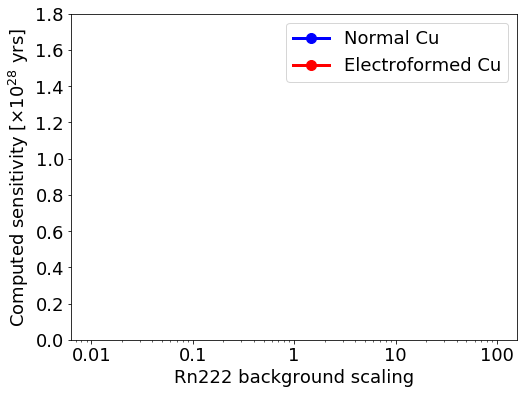

In [33]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

x_points = []
y_points = []
# for key,value in mediandict.items():
    
#     if key == 'Baseline': continue
    
#     factor = float(key.replace('x',''))
   
#     #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
#     x_points.append(factor)
#     y_points.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
# x_points = np.array(x_points)
# y_points = np.array(y_points)
# sorted_idxs = np.argsort(x_points)
# x_points = x_points[sorted_idxs]
# y_points = y_points[sorted_idxs]


x_points_d024 = []
y_points_d024 = []
y_err_d024 = []

for key,value in mediandict_d024.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
    err = medianerrdict_d024[key]
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points_d024.append(factor)
    #y_points_d024.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
    y_points_d024.append(ComputeHalflifeFromNumCounts(value))
    y_err_d024.append(err/value**2*3281000/135.8*6e23*0.9*10*np.log(2)*0.96/1.e28)
    
x_points_d024 = np.array(x_points_d024)
y_points_d024 = np.array(y_points_d024)
    
sorted_idxs = np.argsort(x_points_d024)

x_points_d024 = x_points_d024[sorted_idxs]
y_points_d024 = y_points_d024[sorted_idxs]


    
plt.plot(x_points,y_points,'-ob',markersize=10,linewidth=3,label='Normal Cu')
plt.plot(x_points_d024,y_points_d024,'-or',markersize=10,\
         linewidth=3,label='Electroformed Cu')
#plt.errorbar(x_points_d024,y_points_d024,yerr=y_err_d024,\
#                fmt='-or',markersize=10,linewidth=3,label='Electroformed Cu')

plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.,1.8)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])
plt.legend()

for i in range(len(x_points_d024)):
    print('D024 Sensitivity at {:4.4}: {:5.5} yrs'.format(x_points_d024[i],y_points_d024[i]))

output_df = pd.DataFrame({'Rn222 scaling': x_points_d024, 'Sensitivity (yrs)': y_points_d024})
output_df.to_csv('../PaperPlots/Data/d024_sensitivity_vs_rn222.csv',index=False)
    
plt.savefig('Plots/rn222_sensitivity_vs_scale_factor_d023_and_d024.png',dpi=200,bbox_inches='tight')



## D-024 without Rn222 constraints



In [6]:
categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','30.0x']
#categories_list = ['01.0x']
outputdir_d024_nc = '/p/lustre2/lenardo1/sensitivity_output/Jan2_Rn222Study_merged-v10b_OptimizedV1Binning_D024_NoRn222Constraints/'

all_files_d024_nc = os.listdir(outputdir_d024_nc)
h5_files_d024_nc = [filename for filename in all_files_d024_nc if filename.endswith('.h5')]

dfdict_d024_nc = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_d024_nc = [pd.read_hdf(outputdir_d024_nc+filename) for filename in h5_files_d024_nc if '_'+category+'_' in filename]
    dfdict_d024_nc[category] = pd.concat(df_list_d024_nc,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_d024_nc[category])))
    
    
    

Loading data for 0.01x
---> Loaded 2500 toy datasets
Loading data for 00.1x


KeyboardInterrupt: 

In [22]:
# Get the median values of lambda

maskdict_d024_nc = dict()

for key, df in dfdict_d024_nc.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_d024_nc[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_d024_nc[key])/len(maskdict_d024_nc[key])))
            
    

Running 0.01x
---> Convergence fraction: 0.985
Running 00.1x
---> Convergence fraction: 0.987
Running 00.3x
---> Convergence fraction: 0.996
Running 01.0x
---> Convergence fraction: 0.995
Running 03.0x
---> Convergence fraction: 0.996
Running 10.0x
---> Convergence fraction: 0.998
Running 30.0x
---> Convergence fraction: 0.999


Running 0.01x
---> Median 90%CL on signal counts: 5.471 +/- 0.07031
Running 00.1x
---> Median 90%CL on signal counts: 5.631 +/- 0.07107
Running 00.3x
---> Median 90%CL on signal counts: 6.041 +/- 0.0733
Running 01.0x
---> Median 90%CL on signal counts: 6.696 +/- 0.08
Running 03.0x
---> Median 90%CL on signal counts: 7.231 +/- 0.09026
Running 10.0x
---> Median 90%CL on signal counts: 8.201 +/- 0.104
Running 30.0x
---> Median 90%CL on signal counts: 10.25 +/- 0.1276


Text(0.5, 0, '90% CL on signal counts for given toy')

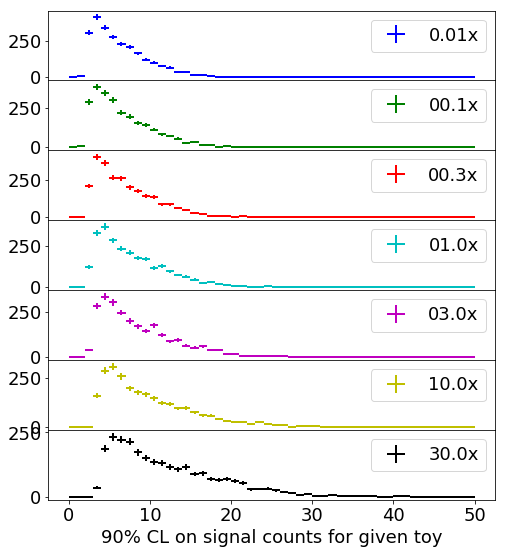

In [23]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,9)

histdict_d024_nc = dict()
mediandict_d024_nc = dict()
medianerrdict_d024_nc = dict()

fig,ax = plt.subplots(ncols=1,nrows=len(dfdict_d024_nc.keys()),\
                      sharex=True,gridspec_kw={'hspace':0})

counter = 0
for key, df in dfdict_d024_nc.items():
    print('Running {}'.format(key))
    
    histdict_d024_nc[key] = hl.hist(dfdict_d024_nc[key]['90CL_crossing'].loc[maskdict_d024_nc[key]], bins=np.linspace(0.,50.,51))
    
    mediandict_d024_nc[key] = np.median(dfdict_d024_nc[key]['90CL_crossing'].loc[maskdict_d024_nc[key]])
    
    medianerrdict_d024_nc[key] = np.std(dfdict_d024_nc[key]['90CL_crossing'].loc[maskdict_d024_nc[key]])/np.sqrt(np.sum(maskdict_d024_nc[key]))
    
    print('---> Median 90%CL on signal counts: {:4.4} +/- {:4.4}'.format(mediandict_d024_nc[key],medianerrdict_d024_nc[key]))
    
    color_idx = counter % len(colors)
    
    hl.plot1d(ax[counter],histdict_d024_nc[key],label=key,\
              linewidth=2,crosses=True,color=colors[color_idx])
    #hl.plot1d(histdict[key],label=key,linewidth=3)
    
#     bincenters = (histdict_d024_nc[key].bins[0][:-1] + histdict_d024_nc[key].bins[0][1:])/2.
#     binvals = histdict_d024_nc[key].values
    
#     plt.plot(bincenters,binvals,label=key,linewidth=3)

    ax[counter].legend()

    counter += 1
    
#plt.legend()
ax[counter-1].set_xlabel('90% CL on signal counts for given toy')
#plt.yscale('log')            


D024 no Rn222 constraints, Sensitivity at 0.01: 1.587 yrs
D024 no Rn222 constraints, Sensitivity at  0.1: 1.5419 yrs
D024 no Rn222 constraints, Sensitivity at  0.3: 1.4372 yrs
D024 no Rn222 constraints, Sensitivity at  1.0: 1.2966 yrs
D024 no Rn222 constraints, Sensitivity at  3.0: 1.2006 yrs
D024 no Rn222 constraints, Sensitivity at 10.0: 1.0586 yrs
D024 no Rn222 constraints, Sensitivity at 30.0: 0.8469 yrs


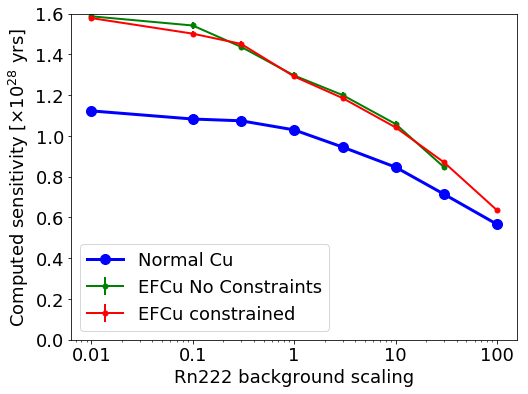

In [24]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

x_points = []
y_points = []
for key,value in mediandict.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points.append(factor)
    y_points.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
x_points = np.array(x_points)
y_points = np.array(y_points)
sorted_idxs = np.argsort(x_points)
x_points = x_points[sorted_idxs]
y_points = y_points[sorted_idxs]


x_points_d024_nc = []
y_points_d024_nc = []
y_err_d024_nc = []

for key,value in mediandict_d024_nc.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
    err = medianerrdict_d024_nc[key]
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points_d024_nc.append(factor)
    y_points_d024_nc.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
    y_err_d024_nc.append(err/value**2*3281000/135.8*6e23*0.9*10*np.log(2)*0.96/1.e28)
    
x_points_d024_nc = np.array(x_points_d024_nc)
y_points_d024_nc = np.array(y_points_d024_nc)
    
sorted_idxs = np.argsort(x_points_d024_nc)

x_points_d024_nc = x_points_d024_nc[sorted_idxs]
y_points_d024_nc = y_points_d024_nc[sorted_idxs]


    
plt.plot(x_points,y_points,'-ob',markersize=10,linewidth=3,label='Normal Cu')
#plt.plot(x_points_d024_nc,y_points_d024_nc,'-or',markersize=10,linewidth=3,label='Electroformed Cu')
plt.errorbar(x_points_d024_nc,y_points_d024_nc,yerr=y_err_d024_nc,fmt='-og',markersize=5,linewidth=2,label='EFCu No Constraints')
plt.errorbar(x_points_d024,y_points_d024,yerr=y_err_d024,fmt='-or',markersize=5,linewidth=2,label='EFCu constrained')

plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.,1.6)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])
plt.legend()
for i in range(len(x_points_d024_nc)):
    print('D024 no Rn222 constraints, Sensitivity at {:4.4}: {:5.5} yrs'.format(x_points_d024_nc[i],y_points_d024_nc[i]))


plt.savefig('Plots/rn222_sensitivity_vs_scale_factor_d023_and_d024_NO_CONSTRAINTS.png',dpi=200,bbox_inches='tight')


## D-024 with Internals_U238 and Rn222 swapped (both constrained)


In [25]:
categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','30.0x']
#categories_list = ['01.0x']
outputdir_d024_swap = '/p/lustre2/lenardo1/sensitivity_output/'+\
            'Jan2_Rn222_OptimizedBinningV1_D-024_InternalsU238_and_Rn222_swapped/'

all_files_d024_swap = os.listdir(outputdir_d024_swap)
h5_files_d024_swap = [filename for filename in all_files_d024_swap if filename.endswith('.h5')]

dfdict_d024_swap = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_d024_swap = [pd.read_hdf(outputdir_d024_swap+filename) for filename in h5_files_d024_swap if '_'+category+'_' in filename]
    dfdict_d024_swap[category] = pd.concat(df_list_d024_swap,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_d024_swap[category])))
    
    
    

Loading data for 0.01x
---> Loaded 5000 toy datasets
Loading data for 00.1x
---> Loaded 2500 toy datasets
Loading data for 00.3x
---> Loaded 2500 toy datasets
Loading data for 01.0x
---> Loaded 2500 toy datasets
Loading data for 03.0x
---> Loaded 2500 toy datasets
Loading data for 10.0x
---> Loaded 2500 toy datasets
Loading data for 30.0x
---> Loaded 2500 toy datasets


In [26]:
# Get the median values of lambda

maskdict_d024_swap = dict()

for key, df in dfdict_d024_swap.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_d024_swap[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_d024_swap[key])/len(maskdict_d024_swap[key])))
            
    

Running 0.01x
---> Convergence fraction: 0.987
Running 00.1x
---> Convergence fraction: 0.99
Running 00.3x
---> Convergence fraction: 0.994
Running 01.0x
---> Convergence fraction: 0.99
Running 03.0x
---> Convergence fraction: 0.984
Running 10.0x
---> Convergence fraction: 0.99
Running 30.0x
---> Convergence fraction: 0.989


Running 0.01x
---> Median 90%CL on signal counts: 5.481 +/- 0.04818
Running 00.1x
---> Median 90%CL on signal counts: 5.581 +/- 0.06979
Running 00.3x
---> Median 90%CL on signal counts: 5.861 +/- 0.07248
Running 01.0x
---> Median 90%CL on signal counts: 6.391 +/- 0.07959
Running 03.0x
---> Median 90%CL on signal counts: 6.921 +/- 0.09107
Running 10.0x
---> Median 90%CL on signal counts: 7.591 +/- 0.1005
Running 30.0x
---> Median 90%CL on signal counts: 8.101 +/- 0.1097


Text(0.5, 0, '90% CL on signal counts for given toy')

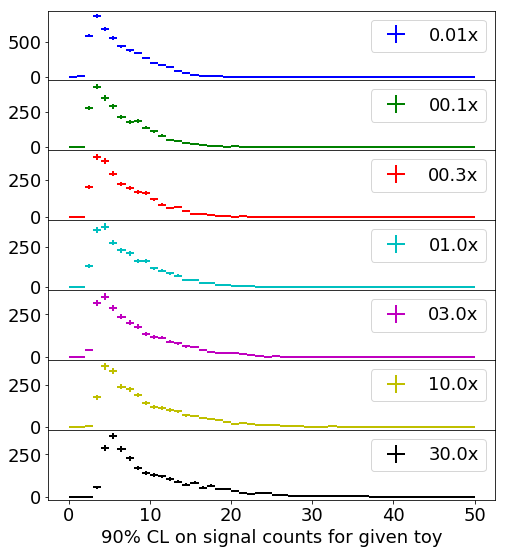

In [27]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,9)

histdict_d024_swap = dict()
mediandict_d024_swap = dict()
medianerrdict_d024_swap = dict()

fig,ax = plt.subplots(ncols=1,nrows=len(dfdict_d024_swap.keys()),\
                      sharex=True,gridspec_kw={'hspace':0})

counter = 0
for key, df in dfdict_d024_swap.items():
    print('Running {}'.format(key))
    
    histdict_d024_swap[key] = hl.hist(dfdict_d024_swap[key]['90CL_crossing'].loc[maskdict_d024_swap[key]], bins=np.linspace(0.,50.,51))
    
    mediandict_d024_swap[key] = np.median(dfdict_d024_swap[key]['90CL_crossing'].loc[maskdict_d024_swap[key]])
    
    medianerrdict_d024_swap[key] = np.std(dfdict_d024_swap[key]['90CL_crossing'].loc[maskdict_d024_swap[key]])/np.sqrt(np.sum(maskdict_d024_swap[key]))
    
    print('---> Median 90%CL on signal counts: {:4.4} +/- {:4.4}'.format(mediandict_d024_swap[key],medianerrdict_d024_swap[key]))
    
    color_idx = counter % len(colors)
    
    hl.plot1d(ax[counter],histdict_d024_swap[key],label=key,\
              linewidth=2,crosses=True,color=colors[color_idx])
    #hl.plot1d(histdict[key],label=key,linewidth=3)
    
#     bincenters = (histdict_d024_swap[key].bins[0][:-1] + histdict_d024_swap[key].bins[0][1:])/2.
#     binvals = histdict_d024_swap[key].values
    
#     plt.plot(bincenters,binvals,label=key,linewidth=3)

    ax[counter].legend()

    counter += 1
    
#plt.legend()
ax[counter-1].set_xlabel('90% CL on signal counts for given toy')
#plt.yscale('log')            


D024 no Rn222 constraints, Sensitivity at 0.01: 1.5841 yrs
D024 no Rn222 constraints, Sensitivity at  0.1: 1.5557 yrs
D024 no Rn222 constraints, Sensitivity at  0.3: 1.4813 yrs
D024 no Rn222 constraints, Sensitivity at  1.0: 1.3585 yrs
D024 no Rn222 constraints, Sensitivity at  3.0: 1.2544 yrs
D024 no Rn222 constraints, Sensitivity at 10.0: 1.1437 yrs
D024 no Rn222 constraints, Sensitivity at 30.0: 1.0717 yrs


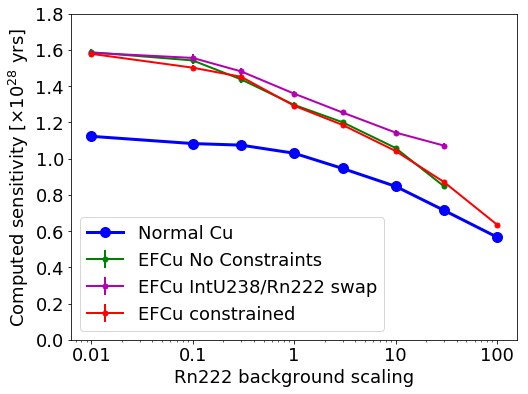

In [29]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

x_points = []
y_points = []
for key,value in mediandict.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points.append(factor)
    y_points.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
x_points = np.array(x_points)
y_points = np.array(y_points)
sorted_idxs = np.argsort(x_points)
x_points = x_points[sorted_idxs]
y_points = y_points[sorted_idxs]


x_points_d024_swap = []
y_points_d024_swap = []
y_err_d024_swap = []

for key,value in mediandict_d024_swap.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
    err = medianerrdict_d024_swap[key]
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points_d024_swap.append(factor)
    y_points_d024_swap.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
    y_err_d024_swap.append(err/value**2*3281000/135.8*6e23*0.9*10*np.log(2)*0.96/1.e28)
    
x_points_d024_swap = np.array(x_points_d024_swap)
y_points_d024_swap = np.array(y_points_d024_swap)
    
sorted_idxs = np.argsort(x_points_d024_swap)

x_points_d024_swap = x_points_d024_swap[sorted_idxs]
y_points_d024_swap = y_points_d024_swap[sorted_idxs]


    
plt.plot(x_points,y_points,'-ob',markersize=10,linewidth=3,label='Normal Cu')
#plt.plot(x_points_d024_nc,y_points_d024_nc,'-or',markersize=10,linewidth=3,label='Electroformed Cu')
plt.errorbar(x_points_d024_nc,y_points_d024_nc,yerr=y_err_d024_nc,fmt='-og',\
             markersize=5,linewidth=2,label='EFCu No Constraints')
plt.errorbar(x_points_d024_swap,y_points_d024_swap,yerr=y_err_d024_swap,fmt='-o',\
             color=(0.7,0.,0.7),markersize=5,linewidth=2,label='EFCu IntU238/Rn222 swap')
plt.errorbar(x_points_d024,y_points_d024,yerr=y_err_d024,fmt='-or',\
             markersize=5,linewidth=2,label='EFCu constrained')

plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.,1.8)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])
plt.legend()

for i in range(len(x_points_d024_swap)):
    print('D024 no Rn222 constraints, Sensitivity at {:4.4}: {:5.5} yrs'.format(x_points_d024_swap[i],y_points_d024_swap[i]))


plt.savefig('Plots/rn222_sensitivity_vs_scale_factor_d023_and_d024_nc_and_swap.png',dpi=200,bbox_inches='tight')




# No radioassay fluctuations

Loading data for 01.0x
---> Loaded 1850 toy datasets
Running 01.0x
---> Convergence fraction: 0.971
Running 01.0x
---> Median 90%CL on signal counts: 8.600860086008602


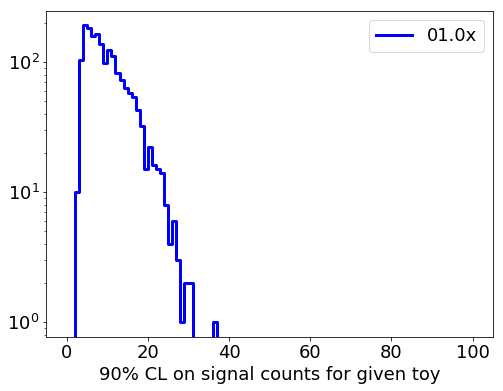

In [17]:
categories_list = ['01.0x']
#categories_list = ['01.0x']
outputdir_d023_norad = '/p/lustre2/lenardo1/sensitivity_output/Nov28_Rn222_OptimizedBinningV1_D-023_NoRadioassayFluctuations/'

all_files_d023_norad = os.listdir(outputdir_d023_norad)
h5_files_d023_norad = [filename for filename in all_files_d023_norad if filename.endswith('.h5')]

dfdict_d023_norad = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_d023_norad = [pd.read_hdf(outputdir_d023_norad+filename) for filename in h5_files_d023_norad if '_'+category+'_' in filename]
    dfdict_d023_norad[category] = pd.concat(df_list_d023_norad,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_d023_norad[category])))
    
    
# Get the median values of lambda
maskdict_d023_norad = dict()

for key, df in dfdict_d023_norad.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_d023_norad[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_d023_norad[key])/len(maskdict_d023_norad[key])))
            
histdict_d023_norad = dict()
mediandict_d023_norad = dict()


for key, df in dfdict_d023_norad.items():
    print('Running {}'.format(key))
    
    histdict_d023_norad[key] = hl.hist(dfdict_d023_norad[key]['90CL_crossing'].loc[maskdict_d023_norad[key]], bins=np.linspace(0.,100.,101))
    
    mediandict_d023_norad[key] = np.median(dfdict_d023_norad[key]['90CL_crossing'].loc[maskdict_d023_norad[key]])
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict_d023_norad[key]))
    
    hl.plot1d(histdict_d023_norad[key],label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')            

    
    

Median sensitivity: 1.013e+28 yrs
Central 68% quantile: 5.769e+27 -- 1.777e+28 yrs
Central 95% quantile: 3.818e+27 -- 2.413e+28 yrs


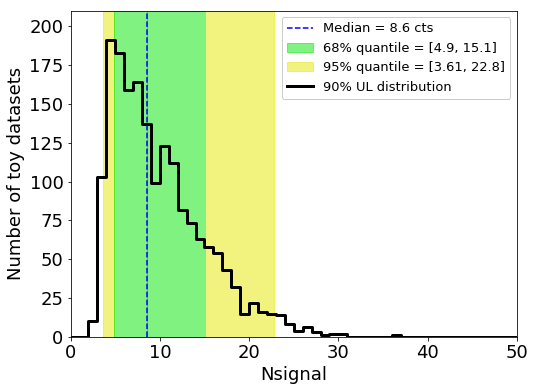

In [18]:
this_median = np.median(dfdict_d023_norad['01.0x']['90CL_crossing'].loc[maskdict_d023_norad['01.0x']])
this_68_quantile = [ np.quantile(dfdict_d023_norad['01.0x']['90CL_crossing'].loc[maskdict_d023_norad['01.0x']],0.16),\
                   np.quantile(dfdict_d023_norad['01.0x']['90CL_crossing'].loc[maskdict_d023_norad['01.0x']],0.84)]
this_95_quantile = [ np.quantile(dfdict_d023_norad['01.0x']['90CL_crossing'].loc[maskdict_d023_norad['01.0x']],0.025),\
                   np.quantile(dfdict_d023_norad['01.0x']['90CL_crossing'].loc[maskdict_d023_norad['01.0x']],0.975)]



BrazilPlot(hist=histdict_d023_norad['01.0x'],\
           median=this_median,\
           quantiles68=this_68_quantile,\
           quantiles95=this_95_quantile,\
           label='d023_no_radioassay_fluctuations')
          
        

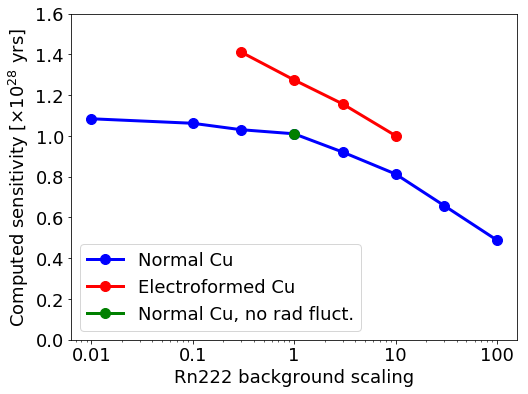

In [23]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

# x_points = []
# y_points = []
# for key,value in mediandict.items():
    
#     if key == 'Baseline': continue
    
#     factor = float(key.replace('x',''))
   
#     #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
#     x_points.append(factor)
#     y_points.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
# x_points = np.array(x_points)
# y_points = np.array(y_points)
# sorted_idxs = np.argsort(x_points)
# x_points = x_points[sorted_idxs]
# y_points = y_points[sorted_idxs]


# x_points_d024 = []
# y_points_d024 = []

# for key,value in mediandict_d024.items():
    
#     if key == 'Baseline': continue
    
#     factor = float(key.replace('x',''))
   
#     #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
#     x_points_d024.append(factor)
#     y_points_d024.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
    
# x_points_d024 = np.array(x_points_d024)
# y_points_d024 = np.array(y_points_d024)
# sorted_idxs = np.argsort(x_points_d024)
# x_points_d024 = x_points_d024[sorted_idxs]
# y_points_d024 = y_points_d024[sorted_idxs]

x_points_d023_norad = []
y_points_d023_norad = []

for key,value in mediandict_d023_norad.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
    
    x_points_d023_norad.append(factor)
    y_points_d023_norad.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
x_points_d023_norad = np.array(x_points_d023_norad)
y_points_d023_norad = np.array(y_points_d023_norad)
sorted_idxs = np.argsort(x_points_d023_norad)
x_points_d023_norad = x_points_d023_norad[sorted_idxs]
y_points_d023_norad = y_points_d023_norad[sorted_idxs]


    
plt.plot(x_points,y_points,'-ob',markersize=10,linewidth=3,label='Normal Cu')
plt.plot(x_points_d024,y_points_d024,'-or',markersize=10,linewidth=3,label='Electroformed Cu')
plt.plot(x_points_d023_norad,y_points_d023_norad,'-og',markersize=10,linewidth=3,label='Normal Cu, no rad fluct.')
plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.,1.6)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])
plt.legend()

plt.savefig('rn222_sensitivity_vs_scale_factor_d023_and_d024_no_rad_fluct.png',dpi=200,bbox_inches='tight')

# Swapping U238 and Rn222

Loading data for 01.0x
---> Loaded 2500 toy datasets
Loading data for 03.0x
---> Loaded 2450 toy datasets
Loading data for 10.0x
---> Loaded 2500 toy datasets
Running 01.0x
---> Convergence fraction: 0.951
Running 03.0x
---> Convergence fraction: 0.917
Running 10.0x
---> Convergence fraction: 0.891
Running 01.0x
---> Median 90%CL on signal counts: 6.261 +/- 0.08463
Running 03.0x
---> Median 90%CL on signal counts: 7.166 +/- 0.09636
Running 10.0x
---> Median 90%CL on signal counts: 8.001 +/- 0.1098


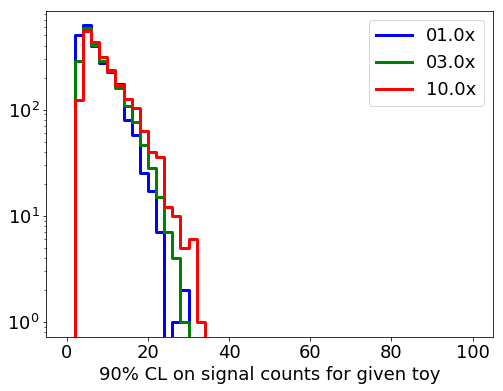

In [24]:
categories_list = ['01.0x','03.0x','10.0x']
outputdir_d024_swap = '/p/lustre2/lenardo1/sensitivity_output/Nov28_Rn222_OptimizedBinningV1_D-024_InternalsU238_and_Rn222_swapped/'

all_files_d024_swap = os.listdir(outputdir_d024_swap)
h5_files_d024_swap = [filename for filename in all_files_d024_swap if filename.endswith('.h5')]

dfdict_d024_swap = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_d024_swap = [pd.read_hdf(outputdir_d024_swap+filename) for filename in h5_files_d024_swap if '_'+category+'_' in filename]
    dfdict_d024_swap[category] = pd.concat(df_list_d024_swap,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_d024_swap[category])))
    
    
# Get the median values of lambda
maskdict_d024_swap = dict()

for key, df in dfdict_d024_swap.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_d024_swap[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_d024_swap[key])/len(maskdict_d024_swap[key])))
            
histdict_d024_swap = dict()
mediandict_d024_swap = dict()
medianerrdict_d024_swap = dict()


for key, df in dfdict_d024_swap.items():
    print('Running {}'.format(key))
    
    histdict_d024_swap[key] = hl.hist(dfdict_d024_swap[key]['90CL_crossing'].loc[maskdict_d024_swap[key]], bins=np.linspace(0.,100.,51))
    
    mediandict_d024_swap[key] = np.median(dfdict_d024_swap[key]['90CL_crossing'].loc[maskdict_d024_swap[key]])
    
    medianerrdict_d024_swap[key] = np.std(dfdict_d024_swap[key]['90CL_crossing'].loc[maskdict_d024_swap[key]])/np.sqrt(np.sum(maskdict_d024_swap[key]))
    
    print('---> Median 90%CL on signal counts: {:4.4} +/- {:4.4}'.format(mediandict_d024_swap[key],medianerrdict_d024_swap[key]))
    
    hl.plot1d(histdict_d024_swap[key],label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')            


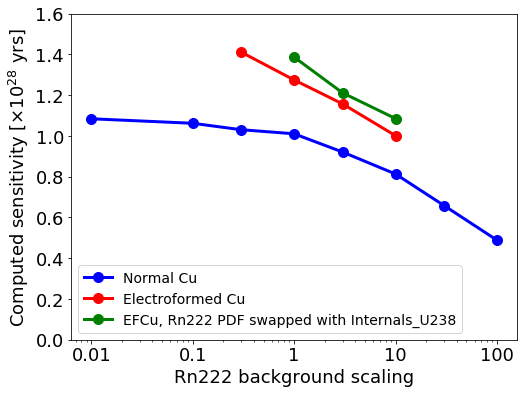

In [25]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

x_points_d024_swap = []
y_points_d024_swap = []

for key,value in mediandict_d024_swap.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
    
    x_points_d024_swap.append(factor)
    y_points_d024_swap.append(3281000/135.8*6e23*0.9*10*np.log(2)*0.96/value/1.e28)
x_points_d024_swap = np.array(x_points_d024_swap)
y_points_d024_swap = np.array(y_points_d024_swap)
sorted_idxs = np.argsort(x_points_d024_swap)
x_points_d024_swap = x_points_d024_swap[sorted_idxs]
y_points_d024_swap = y_points_d024_swap[sorted_idxs]


    
plt.plot(x_points,y_points,'-ob',markersize=10,linewidth=3,label='Normal Cu')
plt.plot(x_points_d024,y_points_d024,'-or',markersize=10,linewidth=3,label='Electroformed Cu')
plt.plot(x_points_d024_swap,y_points_d024_swap,'-og',markersize=10,linewidth=3,label='EFCu, Rn222 PDF swapped with Internals_U238')
plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.,1.6)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Rn222 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.],['0.01','0.1','1','10','100'])
plt.legend(fontsize=14)

plt.savefig('rn222_sensitivity_vs_scale_factor_d023_and_d024_with_swap_results.png',dpi=200,bbox_inches='tight')



